In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
import graphviz

In [61]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')

# The Dataset

Our dataset was obtained from the Census Bureau and has the salaries and demographic variables of 48,842 people. The goal of this decision tree classifier is to predict whether people make more than 50k or less than 50k. In order to prepare our dataset for this model, variables had to be binned.

**Q1: Why does it make sense to discretize columns for this problem?**
Decision trees work well when meaningful splits can be made in features. This would be hard to do if our features contained continuous values. By discretizing the columns into bins, we allow the model to make splits that actually matter rather than picking some arbitrary point in a continous value.

**Q2: What might be the issues if we DID NOT discretize the columns?**
If we did not discretize the columns, our tree could grow very large and complex as splits would be based on lots of unique values. The model could start to focus on smaller variations which may lead to overfitting. Instead, by discretizing the columns we can have our model focus on more generalizable patterns making our model more robust and true to real life.

# Data Quality Analysis

In [62]:
df.head(10)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
5,b. 31-40,e. High,c. High,a. = 0,b. Mid,d. 14,d. Masters,b. income,d. 36-40 & 56-60,train,0
6,a. 0-30,a. Low,b. Mid,a. = 0,a. Low,a. 0-8,a. Low,b. income,e. 40-55,train,0
7,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,1
8,d. 41-50 & 61-70,e. High,b. Mid,c. > 0,b. Mid,d. 14,d. Masters,b. income,c. 31-35 & 61-70,train,1
9,b. 31-40,e. High,c. High,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [7]:
#checking for percent of missing values
df.isna().sum()/len(df)*100
#no missing values found

hours_per_week_bin    0.0
occupation_bin        0.0
msr_bin               0.0
capital_gl_bin        0.0
race_sex_bin          0.0
education_num_bin     0.0
education_bin         0.0
workclass_bin         0.0
age_bin               0.0
flag                  0.0
y                     0.0
dtype: float64

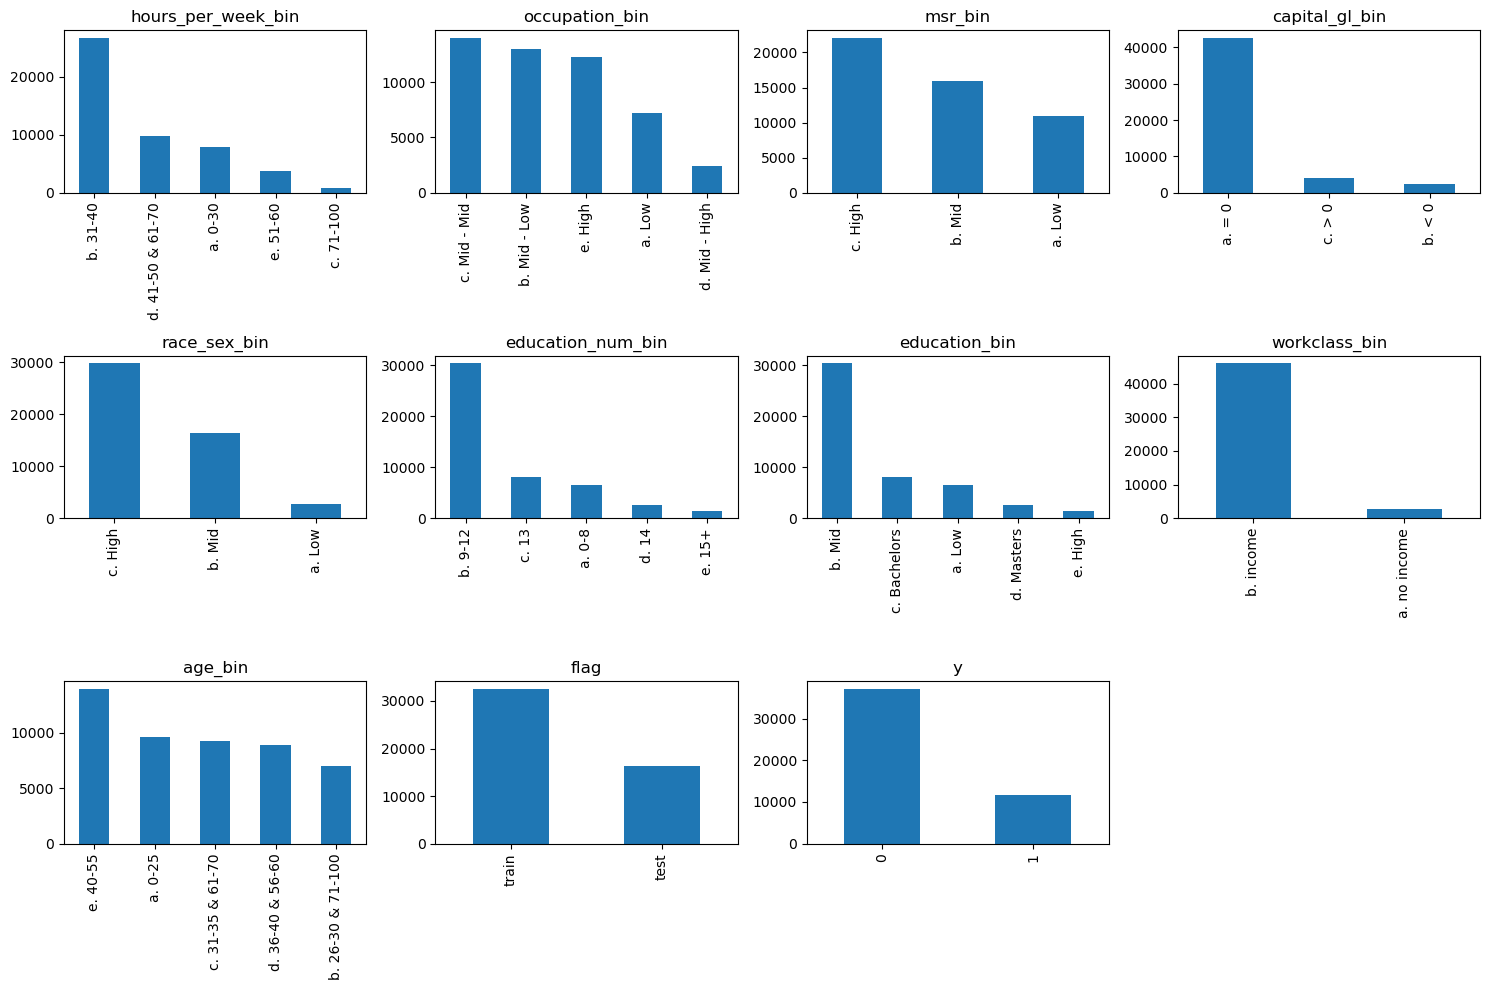

In [8]:
#visualizing the distribution of our columns, using a grid format for
#enhanced readability
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(15,10))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    df[column].value_counts().plot(kind='bar', ax=axes[i], title=column)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Not too much to note about column distributions. The capital gains column seems to be overwhelmingly 0 and the workclass seems to be mostly income. Running some correlation tests can help us determine how useful these kinds of columnsa are.

In [9]:
#descriptive statistics
df.describe(include=[object])

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,5,5,3,3,3,5,5,2,5,2
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561


Our descriptive statistics show us similar trends to our distributions above. We also get a sense of who our average individual from the dataset is.

In [10]:
# checking for imbalances in our target variable, making sure we have enough positives
df['y'].value_counts()/df['y'].count()

# it's 76% negative vs. 23% positive. Not quite the 70/30 split we'd like but there
# are enough records that it shouldn't be too much of a problem

0    0.760718
1    0.239282
Name: y, dtype: float64

In [11]:
# noticing a pattern among the binned variables that they have a., b. or c. in front
# of the values.

df = df.applymap(lambda x: x.split('. ', 1)[-1] if isinstance(x, str) else x)

# this splits at the period after the letter and removes both the period and the letter

In [12]:
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


# Data Quality Report

In [13]:
#generating our data quality report
categorical = df.select_dtypes(include=object)
cols = ['Count', '%Missing', 'Cardinality', 'Mode']
categorical_dqr = pd.DataFrame(columns=cols, index=categorical.columns)

for col in categorical.columns:
    column_data = categorical[col]
    count = column_data.count()
    missing = column_data.isna().sum()/len(categorical)*100
    cardinality = column_data.nunique()
    mode = column_data.mode().iloc[0]
    categorical_dqr.loc[col, ['Count', '%Missing', 'Cardinality', 'Mode']] = [count, missing, cardinality, mode]
categorical_dqr

,Count,%Missing,Cardinality,Mode
hours_per_week_bin,48842,0.0,5,31-40
occupation_bin,48842,0.0,5,Mid - Mid
msr_bin,48842,0.0,3,High
capital_gl_bin,48842,0.0,3,= 0
race_sex_bin,48842,0.0,3,High
education_num_bin,48842,0.0,5,9-12
education_bin,48842,0.0,5,Mid
workclass_bin,48842,0.0,2,income
age_bin,48842,0.0,5,40-55
flag,48842,0.0,2,train


From our data quality report we once again see none of our columns have missing values and our cardinality and modes look healthy.

# Encoding

In order to prepare the dataset for the model and test correlations I will encode it. Based on the feature types, like ordinal or nominal, I will encode them with either ordinal encoding or one-hot encoding.

In [14]:
ordinal_cols = ["education_num_bin", "education_bin", "occupation_bin", "msr_bin", "race_sex_bin"]
one_hot_cols = ["hours_per_week_bin", "capital_gl_bin", "workclass_bin", "age_bin"]

I'm placing columns in the ordinal_cols list based on what their values look like. I'm not sure why there would be a low, medium, and high for occupation or race sex but the variables show that there is some order. The one hot cols list are the rest of the columns minus the y and the flag columns.

In [16]:
ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

In [17]:
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=False)

# Correlations

In [18]:
# dropping flag as we're splitting on this and getting rid of it as soon as our
# data is ready
df_for_corr = df.drop('flag', axis=1)

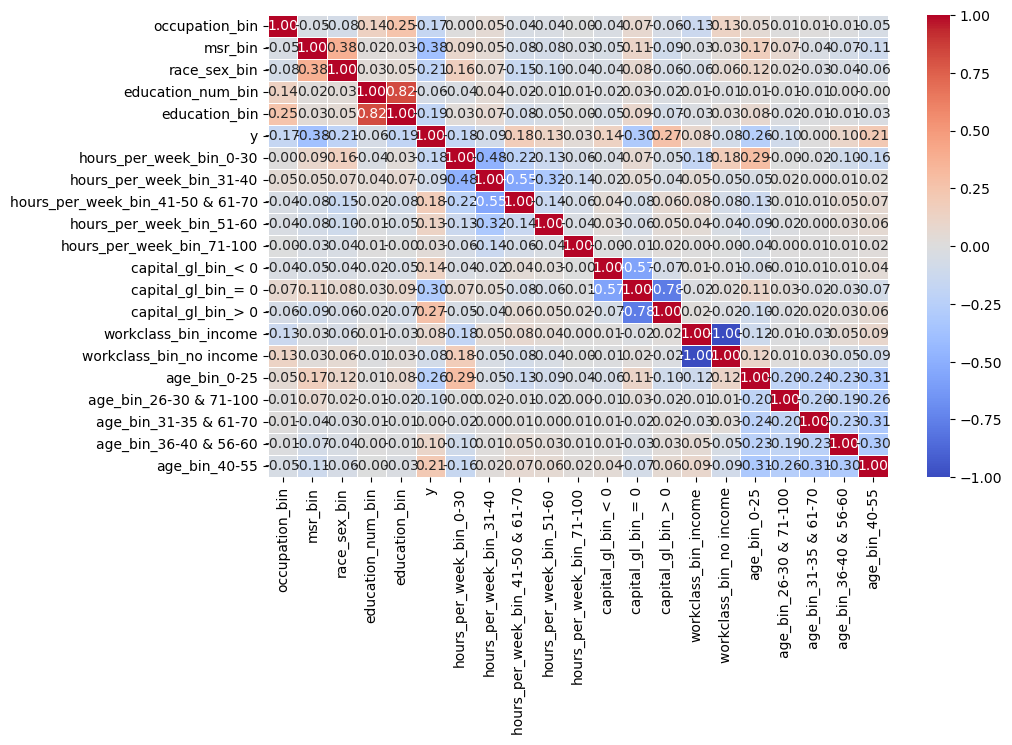

In [19]:
plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.heatmap(df_for_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

We see some high correlations among different levels of the same variable which aren't too much of a surprise. However, our education_num_bin and our education_bin are two seperate columns essentially saying the same thing now that they're encoded. I will stick with education_bin for easier interpretability.

In [20]:
df.drop('education_num_bin', axis=1, inplace=True)

In [21]:
# a last look at our cleaned and transformed dataset before splitting
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   occupation_bin                    48842 non-null  float64
 1   msr_bin                           48842 non-null  float64
 2   race_sex_bin                      48842 non-null  float64
 3   education_bin                     48842 non-null  float64
 4   flag                              48842 non-null  object 
 5   y                                 48842 non-null  int64  
 6   hours_per_week_bin_0-30           48842 non-null  uint8  
 7   hours_per_week_bin_31-40          48842 non-null  uint8  
 8   hours_per_week_bin_41-50 & 61-70  48842 non-null  uint8  
 9   hours_per_week_bin_51-60          48842 non-null  uint8  
 10  hours_per_week_bin_71-100         48842 non-null  uint8  
 11  capital_gl_bin_< 0                48842 non-null  uint8  
 12  capi

# Splitting the data

splitting the data based on the flag column and then splitting into our X and our y

In [22]:
train_df = df[df['flag'] == 'train'].drop(columns=['flag'])
test_df = df[df['flag'] == 'test'].drop(columns=['flag'])

In [23]:
X_train = train_df.drop(columns=['y'])
y_train = train_df['y']

In [24]:
X_test = test_df.drop(columns=['y'])
y_test = test_df['y']

# Model Development

Starting with the hyperparameters specified in our assignment guide, will finetune these later on.

In [25]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=101,
                               max_features=None, min_samples_leaf=15)
dtree.fit(X_train, y_train)
y_pred=dtree.predict(X_test)

Let's start by looking at our confusion matrix.

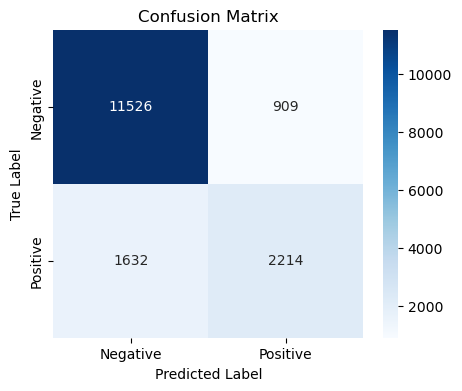

In [26]:
def confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
confusion(y_test, y_pred)

We can see that our model is predicting negatives relatively accurately but misclassifying positives alot. Let's look at our other performance metrics to quantify this.

In [27]:
def performance(y_test, y_pred):    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

performance(y_test, y_pred)

{'Accuracy': 0.843928505620048,
 'Precision': 0.7089337175792507,
 'Recall': 0.5756630265210608,
 'F1 Score': 0.6353852776582006}

Our recall is the most concering metric here. Our model is missing alot of actual positives. We'll fine tune the hyperparamters to try and achieve better recall.

# Hyper Parameter Tuning (Q3)

Here we're creating lists of the hyperparameter values we want to test.

In [28]:
split_criteria_list = ['entropy', 'gini']
min_samples_leaf_list = [5, 10, 15, 20, 25, 30, 35, 40]
max_features_list = [None, .3, .4, .5, .6, .7, .8]
max_depth_values_list = [2, 4, 6, 8, 10, 12, 14, 16]

First testing split criteria

In [44]:
results = []
for criterion in split_criteria_list:
    dtree = DecisionTreeClassifier(criterion=criterion, random_state=101)
    dtree.fit(X_train, y_train)
    y_pred=dtree.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["Split Criterion"] = criterion
    results.append(metrics)

df_run1 = pd.DataFrame(results)
print("Run 1 Results:\n", df_run1)


Run 1 Results:
    Accuracy  Precision    Recall  F1 Score Split Criterion
0  0.836312   0.690668  0.556162  0.616160         entropy
1  0.836558   0.691810  0.555642  0.616294            gini


It seems that gini is the way to go as most of our scores are marginally higher. Nex we'll look at min_samples_leaf

In [45]:
results = []

for min_samples in min_samples_leaf_list:
    dtree = DecisionTreeClassifier(criterion='gini', random_state=101,
                                   min_samples_leaf=min_samples)
    dtree.fit(X_train, y_train)
    y_pred=dtree.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["Min Samples Leaf"] = min_samples
    results.append(metrics)

df_run2 = pd.DataFrame(results)
print("Run 2 Results:\n", df_run2)

Run 2 Results:
    Accuracy  Precision    Recall  F1 Score  Min Samples Leaf
0  0.840857   0.703668  0.563703  0.625956                 5
1  0.840489   0.702957  0.562402  0.624874                10
2  0.842762   0.706752  0.571503  0.631972                15
3  0.842823   0.706316  0.572803  0.632592                20
4  0.843069   0.711848  0.563963  0.629334                25
5  0.841779   0.710683  0.556942  0.624490                30
6  0.842516   0.713952  0.556162  0.625256                35
7  0.841533   0.708224  0.559802  0.625327                40


Plotting to easily see where our best min samples leaf and accuracy combo are

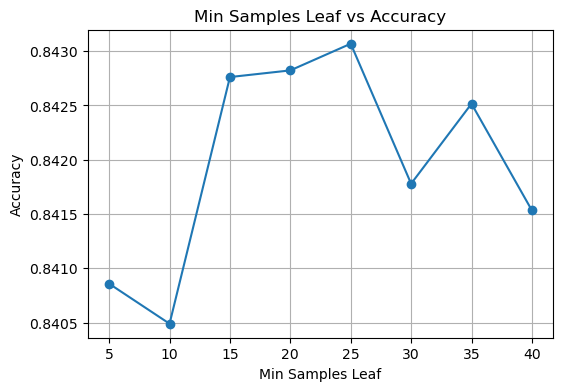

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(min_samples_leaf_list, df_run2["Accuracy"], marker='o')
plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy")
plt.title("Min Samples Leaf vs Accuracy")
plt.grid()
plt.show()

It seems 25 is our best best. Let's test our max features next.

In [47]:
results = []

for max_features in max_features_list:
    dtree = DecisionTreeClassifier(criterion='gini', random_state=101,
                                   min_samples_leaf=25, max_features=max_features)
    dtree.fit(X_train, y_train)
    y_pred=dtree.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["Max Features"] = max_features
    results.append(metrics)

df_run3 = pd.DataFrame(results)
print("Run 2 Results:\n", df_run3)

Run 2 Results:
    Accuracy  Precision    Recall  F1 Score  Max Features
0  0.843069   0.711848  0.563963  0.629334           NaN
1  0.840366   0.697373  0.572803  0.628979           0.3
2  0.840120   0.707929  0.550182  0.619166           0.4
3  0.841103   0.697769  0.577483  0.631953           0.5
4  0.842332   0.710431  0.561362  0.627160           0.6
5  0.840305   0.704128  0.558762  0.623079           0.7
6  0.842024   0.704036  0.571503  0.630884           0.8


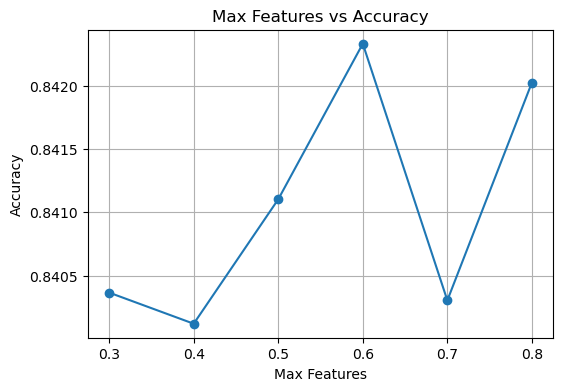

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(max_features_list, df_run3["Accuracy"], marker='o')
plt.xlabel("Max Features")
plt.ylabel("Accuracy")
plt.title("Max Features vs Accuracy")
plt.grid()
plt.show()

It seems .6 is the best value for max features. Next we'll test max depth.

In [49]:
results = []

for max_depth in max_depth_values_list:
    dtree = DecisionTreeClassifier(criterion='gini', random_state=101,
                                   min_samples_leaf=25, max_features=.6,
                                   max_depth=max_depth)
    dtree.fit(X_train, y_train)
    y_pred=dtree.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["Max Depth"] = max_depth
    results.append(metrics)

df_run4 = pd.DataFrame(results)
print("Run 2 Results:\n", df_run4)

Run 2 Results:
    Accuracy  Precision    Recall  F1 Score  Max Depth
0  0.788956   0.606994  0.302392  0.403679          2
1  0.830109   0.656794  0.588144  0.620576          4
2  0.837909   0.697416  0.554342  0.617702          6
3  0.838831   0.700065  0.555902  0.619710          8
4  0.843499   0.703704  0.582943  0.637656         10
5  0.838953   0.693548  0.570203  0.625856         12
6  0.844788   0.720790  0.559802  0.630177         14
7  0.842024   0.707492  0.564743  0.628109         16


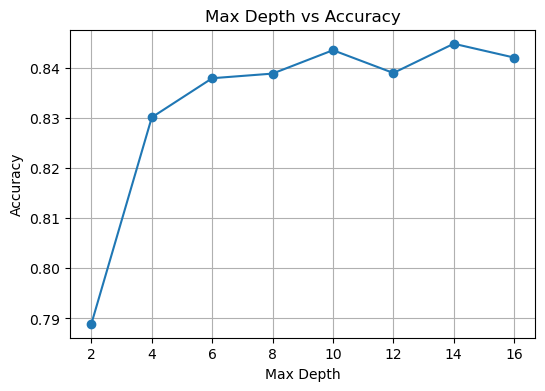

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(max_depth_values_list, df_run4["Accuracy"], marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Max Depth vs Accuracy")
plt.grid()
plt.show()

Max depth of 14 seems ideal. In all we have split criteria set to entropy, min sample leafs at 25, max features at .6 and max depth at 14.

# The Final Model and Tree Visualization

In [79]:
dtree = DecisionTreeClassifier(criterion='gini', random_state=101,
                               max_features=.6, max_depth=14, min_samples_leaf=25)
dtree.fit(X_train, y_train)
y_pred=dtree.predict(X_test)

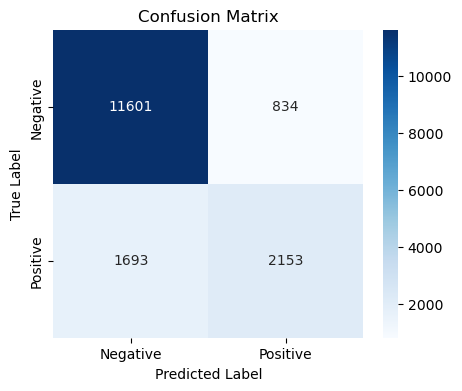

In [80]:
confusion(y_test, y_pred)

In [81]:
performance(y_test, y_pred)

{'Accuracy': 0.8447884036607088,
 'Precision': 0.7207900903916974,
 'Recall': 0.5598023920956838,
 'F1 Score': 0.6301770818088688}

In [82]:
# in order to get graphviz to work I have to clean the feature names.

clean_feature_names = [
    f.replace("&", "and")
     .replace("<", "less")
     .replace(">", "greater")
     .replace("=", "equals")
     .replace(".", "_")  # Replace periods to avoid issues
    for f in X_train.columns
]

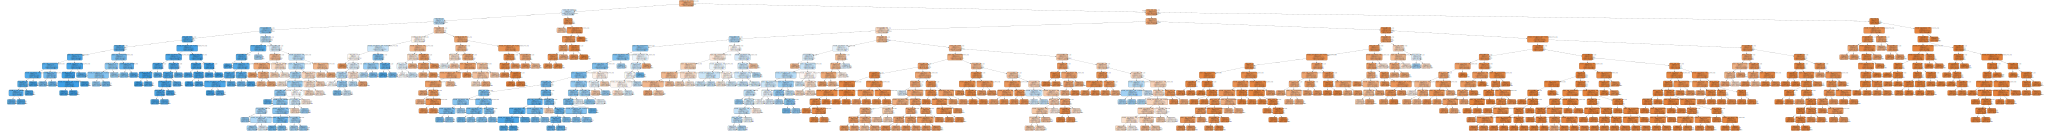

In [83]:
dot_data = export_graphviz(dtree, out_file=None, feature_names=clean_feature_names, 
                           class_names=["Negative", "Positive"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph

# Conclusion

**Q4. Performance Metrics:** We can see that we have a marginal .01% bump in our accuracy and a 2% bump in our precision. However, our recall went down by 2%. This is concerning as this was our lowest metric to being with. This shows that our discriminatory powers in this model in terms of finding actual positives is not as good as our first model. Despite, our F1 score went up because of our precision. Perhaps tuning based on our recall score might have been the way to go in this case.

**Q5. Run time:** The run time to train the best model was very quick, less than a second. To actually reach the step where we were able to confidently test the best model took much longer. I had to loop through each hyper parameter in order to find which values had the most impact on accruacy and graph that to make it more interpretable.

**Q6. Visualization Observations:** Our tree seems to have grown quite alot. It is pretty deep with multiple levels. As we'd expect, many of our classifications are negative with the positive ones being fairly reliant on features like capital gains, age, and occupation. It also seems our model is combining features like age categories which introduces further complexity.

**Q7. Risk of Overfitting:** Based on the depth of our model, it does seem that it could overfit if grown further. Our metrics are not high enough to indicate over fitting and we've restricted our tree depth so that it can't get fully grown. 14 is already quite high, so increasing this number could lead us to see some overfitting. The tree is already quite large and complex, meaning overfitting is certainly possible as it finds more unique and complex splits.

# Predicting an Example

This is the example we're testing:
* Hours Worked per Week = 48
* Occupation Category = Mid - Low
* Marriage Status & Relationships = High
* Capital Gain = Yes
* Race-Sex Group = Mid
* Number of Years of Education = 12
* Education Category = High
* Work Class = Income
* Age = 58

In [75]:
# making df in shape of our training data
example = [3.0, 3.0, 2.0, 2.0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
example_df = pd.DataFrame([example], columns=X_train.columns)

In [76]:
example_pred = dtree.predict(example_df)

if example_pred[0] == 0:
    pred = ">50k"
else:
    pred = "<=50k"
    

print("Predicted Class: ", pred)

Predicted Class:  <=50k


**Q8.** Let's see what the probability and confidence score of our prediction is

In [78]:
# Get probability estimates for the example
example_proba = dtree.predict_proba(example_df)

# Print the probability of belonging to class 1 (>50K) and class 0 (<=50K)
print("Probability scores:", example_proba[0])

# Get the highest probability (the model’s confidence in its prediction)
confidence_score = max(example_proba[0])
print("Probability of our guess:", confidence_score)


Probability scores: [0.375 0.625]
Probability of our guess: 0.625


62.5% confident that our prediction is correct.